# Aggregate multiple datasets to one

Thsi section defines some stuff for running the script. 

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import os
import itertools
import numpy as np
import pandas as pd

from results_helper import (
    MODELS, 
    MODELS_FULL,
    MODELS_SHORT,
    PROMPT_METHODS,
    PROMPT_METHODS_WITHOUT_ALIGNER,
    DATASETS,
    DATASETS_FULL,
    DATASET_LENS,
    DATASET_SHORT_DICT,
    TARGET_DATASET,
    ROBUST_PATH,
    DATASET_PREFERENCES,
    METRICS,
    METRIC_LABELS,
    RELEVANCE, 
    RELEVANCE_DICT, 
)

from results_helper import aggregate, split_to_df_by_dataset
results_dict = aggregate(relevance=["relevant", "irrelevant", "irrelevant_set"], verbose=False, use_eval=True)

Found 41/195 full datasets


In [41]:
results_dict = split_to_df_by_dataset(results_dict, verbose=True)
print(results_dict)
results_dict.print_data()

MultiKeyDict with 359 entries:
Custom Keys: ['relevance', 'method', 'model', 'dataset', 'field']
Categorical Fields:
  - relevance(3): ['relevant', 'irrelevant_set', 'irrelevant']
  - method(5): ['direct', 'cot', 'icl', 'self_critic', 'aligner']
  - model(13): ['Llama-3.1-8B-Instruct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'Mistral-7B-Instruct-v0.3', 'janus-7b', 'Mixtral-8x7B-Instruct-v0.1', 'gpt-4o-mini-2024-07-18', 'DeepSeek-R1-Distill-Llama-70B-free', 'gemma-2-9b-it', 'gemma-2-27b-it', 'Qwen3-8B', 'Qwen3-8B_thinking', 'Qwen3-32B', 'Qwen3-32B_thinking']
  - dataset(4): ['commonsense_qa', 'mmlu', 'truthful_qa', 'full']
  - Fields(len 2): ['df', 'dataset_path']

Data:
  - ('relevant', 'direct', 'Llama-3.1-8B-Instruct', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.1-8B-Instruct-direct-full_eval.csv
  - ('relevant', 'direct', 'Llama-3.3-70B-Instruct-Turbo-Free', 'full', 'dataset_path'): results/mcq_results/relevant/direct/full/Llama-3.3-70B-Instruct-Turbo-Free

## Table of scores

BR = 1-(Robust(q, P) | Correct_no_pref(q))

RDR = 1-(Robust(q, P) / Correct_no_pref(q))

AFR = 1 - (Robust(q, P) / Correct_pref(q, P))

PVR = (Correct_nopref(q) & Correct_pref(q, P)) / (Correct_nopref(q) | Correct_pref(q, P))

Compute per model, per dataset and full dataset

In [42]:
from results_helper import (MODELS_SHORT_DICT, compute_metrics, print_metric_table)

# Compute metrics
results_dict = compute_metrics(results_dict, verbose=False)

# Debug print values
print_metric_table(
    results_dict,
    # relevances=["relevant"],
)

-------------------- ('relevant', 'Relevant') --------------------

-------------------- direct --------------------
Llama3-8B		& 11.8\% & 18.0\% & 18.1\% & 16.8\% & 12.8\% & 23.4\% & 19.9\% & 20.9\% & \textbf{1.1}\% & 6.6\% & 2.1\% & 5.0\% & 19.2\% & 30.8\% & 28.2\% & 28.3\% \\
Llama3-70B		& \textbf{3.1}\% & \textbf{6.0}\% & \textbf{7.3}\% & \textbf{5.6}\% & \textbf{4.3}\% & \textbf{10.1}\% & \textbf{9.9}\% & \textbf{9.0}\% & 1.2\% & 4.4\% & 2.8\% & 3.6\% & \textbf{6.5}\% & \textbf{10.2}\% & \textbf{12.0}\% & \textbf{9.8}\% \\
Mistral-7B		& 20.5\% & 27.3\% & 32.2\% & 26.3\% & 27.5\% & 34.4\% & 42.8\% & 33.8\% & 8.8\% & 9.8\% & 15.6\% & 10.2\% & 25.5\% & 37.2\% & 36.6\% & 34.6\% \\
Janus-7B		& 14.2\% & 24.7\% & 19.8\% & 21.9\% & 29.9\% & 34.7\% & 43.5\% & 34.6\% & 18.3\% & 13.3\% & 29.6\% & 16.3\% & 40.4\% & 48.5\% & 39.7\% & 45.9\% \\
Mixtral-8x7B		& 12.5\% & 18.2\% & 19.9\% & 17.3\% & 17.8\% & 27.0\% & 34.2\% & 26.1\% & 6.1\% & 10.8\% & 17.9\% & 10.7\% & 19.1\% & 27.6\% & 24.8\% & 25

## Scatter Plot of AVF vs BR

In [43]:
## TBD Code deleted by accident
from results_helper import filter_axis, named_scatter

scatter_metric_combos = [
    ("BR", "AFR", "RER")
]

for combo in scatter_metric_combos:
    metric1, metric2, metric3 = combo
    
    data, order = results_dict.get_field_matrix(
        field=[metric1, metric2, metric3],
        fixed_keys={
            "dataset": "full",
            "relevance": "relevant",
            "method": "direct",
        },
        axis_keys=["model"]
    )
    data = np.array(data)
    print(data.shape, order)
    
    data, _, scatter_model_names = filter_axis(
        data,
        axis=1,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape, scatter_model_names)

    named_scatter(
        data[0],
        data[1],
        keys=scatter_model_names,
        title=f"{metric2} vs {metric1} Scatter Plot",
        xlabel=METRIC_LABELS[metric1],
        ylabel=METRIC_LABELS[metric2],
        scores=data[2],
        show=False,
    )

(3, 13) ['field', 'model']
(3, 12) ['Llama3-8B', 'Llama3-70B', 'Mistral-7B', 'Janus-7B', 'Mixtral-8x7B', 'GPT-4o-mini', 'DeepSeek-R1-70B', 'Gemma-2-9B', 'Gemma-2-27B', 'Qwen3-8B', 'Qwen3-8B-Thinking', 'Qwen3-32B']
Modifying


## Horizontal Bidirectional Bar Plot for Relevant/Mixed

(13, 3)
(5, 3)


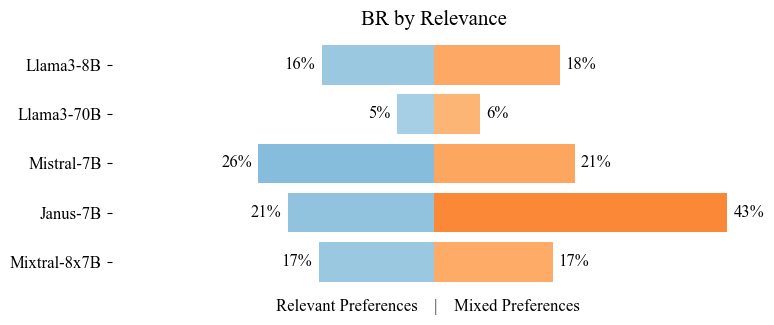

(13, 3)
(5, 3)


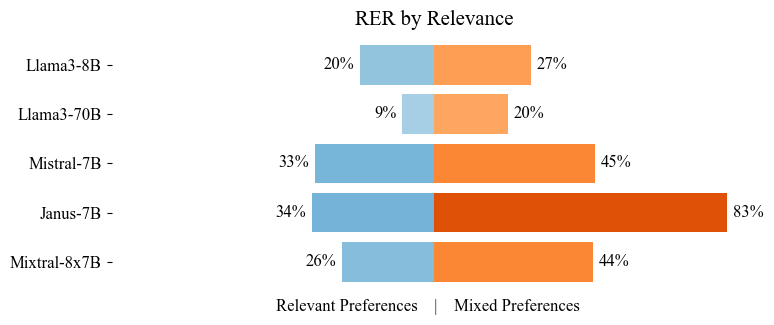

(13, 3)
(5, 3)


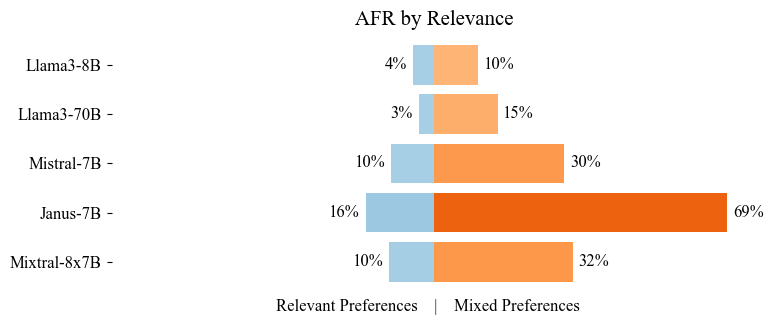

(13, 3)
(5, 3)


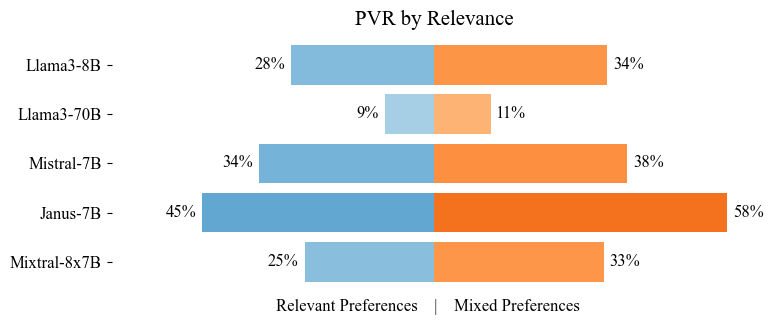

In [44]:
from results_helper import rel_irrel_backback_barplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    rel_irrel_backback_barplot(
        data[:, 0],
        data[:, 1],
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        show=True,
    )



## Horizontal Bar Plot for Relevant/Irrelevant/Mixed

(13, 3)
(5, 3)


/Users/danielhou/Code/pref_aligner/results_helper.py:1058: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


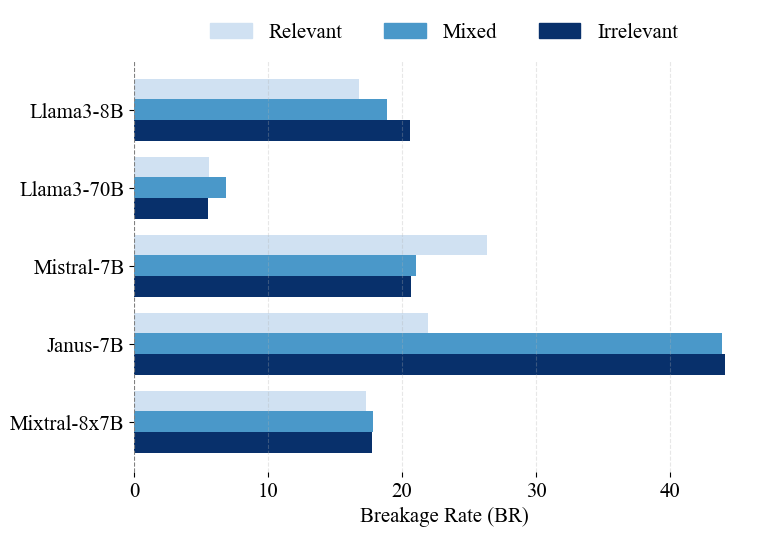

(13, 3)
(5, 3)


/Users/danielhou/Code/pref_aligner/results_helper.py:1058: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


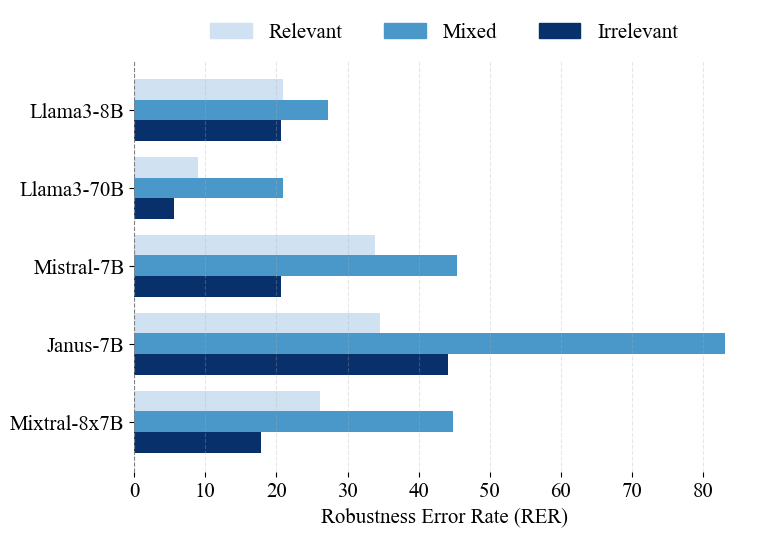

(13, 3)
(5, 3)


/Users/danielhou/Code/pref_aligner/results_helper.py:1058: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


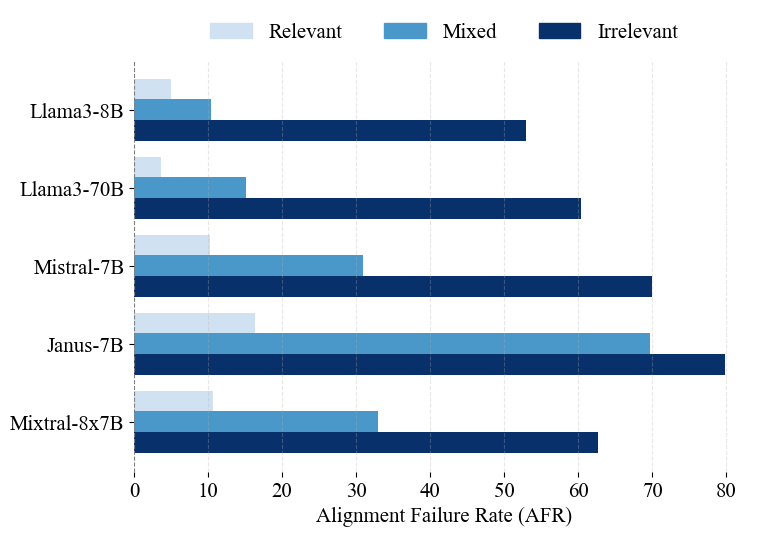

/Users/danielhou/Code/pref_aligner/results_helper.py:1058: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


(13, 3)
(5, 3)


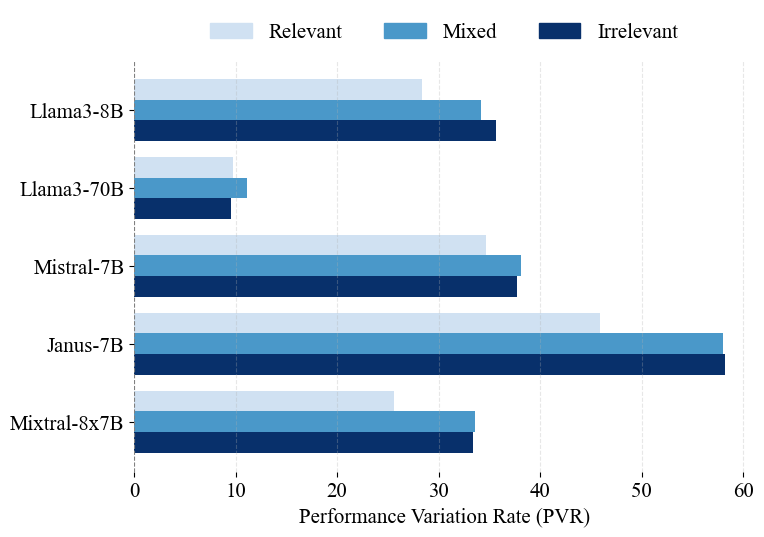

In [45]:
from results_helper import relevance_hbarplot, filter_axis

matrices = []

for metric in METRICS:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "method": "direct",
            "dataset": "full",
        },
        axis_keys=["model", "relevance"]
    )
    data = np.array(data).squeeze()
    print(data.shape)
    data, _, model_names_rel_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    
    relevance_hbarplot(
        data,
        relevance_list=RELEVANCE,
        models=model_names_rel_hb,
        title=f"{metric} by Relevance",
        xlabel=METRIC_LABELS[metric],
        show=True,
    )



## Horizontal Bar Plot for Prompt Methods

(13, 5)
(3, 5)
(13, 5)
(3, 5)
(13, 5)
(3, 5)


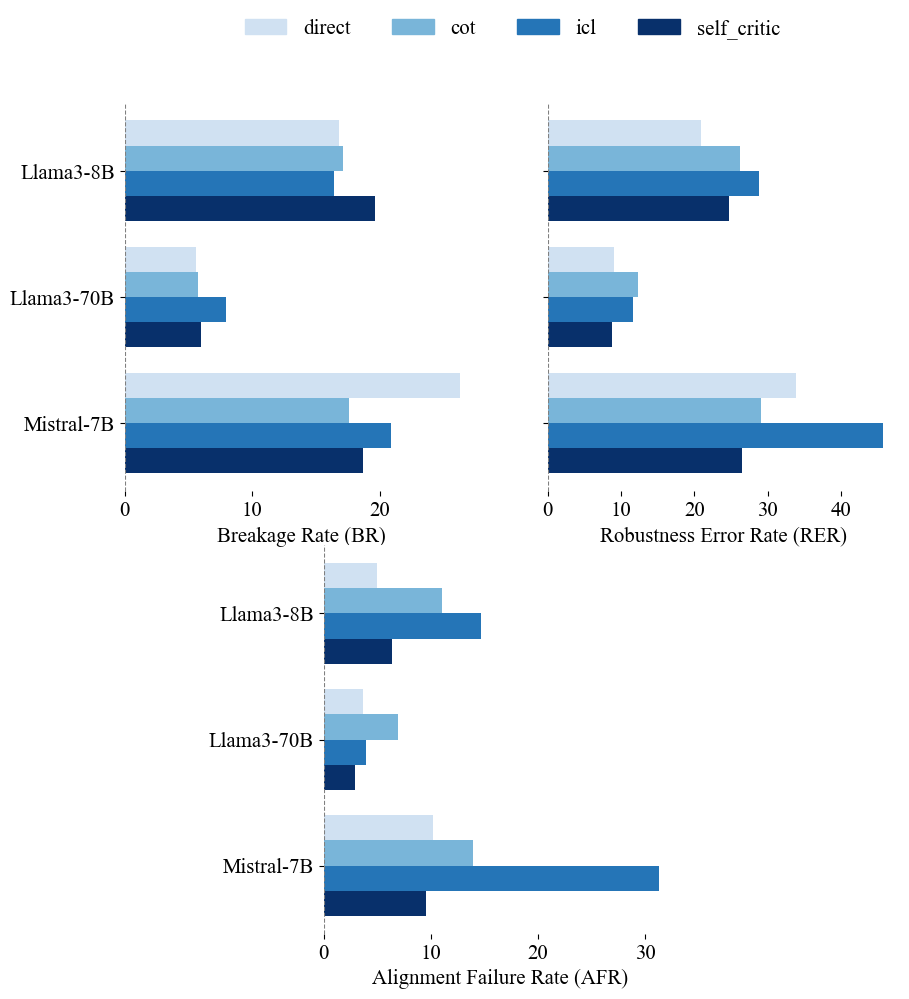

In [46]:
from results_helper import PROMPT_METHODS_WITHOUT_ALIGNER, method_hbarplot, filter_axis

matrices = []

metrics_wo_pvr = ["BR", "RER", "AFR"]
for metric in metrics_wo_pvr:
    data, order = results_dict.get_field_matrix(
        field=metric,
        fixed_keys={
            "relevance": "relevant",
            "dataset": "full",
        },
        axis_keys=["model", "method"]
    )
    data = np.array(data).squeeze()
    print(data.shape)

    data, _, model_names_hb = filter_axis(
        data, 
        axis=0,
        filter_val=None,
        labels_to_filter=MODELS_SHORT,
    )
    print(data.shape)
    matrices.append(data)

method_hbarplot(
    matrices,
    methods=PROMPT_METHODS_WITHOUT_ALIGNER,
    models=model_names_hb,
    subplot_titles=metrics_wo_pvr,
    title="Metrics with Various Prompting Methods",
    show=True,
)


## MC Return Valid Answer Drop in Probability

(2, 13)
[[ 0.4162042   0.04162042  0.8462819   1.8312986   0.87402886  3.135405
  21.947836    0.263596    0.4162042  10.474473   17.064373   11.792453  ]
 [ 0.72142065  0.09711432  1.2208657   2.691454    1.0127636   8.837403
  19.866816    0.7630411   0.7352941  10.668701   14.095449   17.216982  ]]
(2, 12)


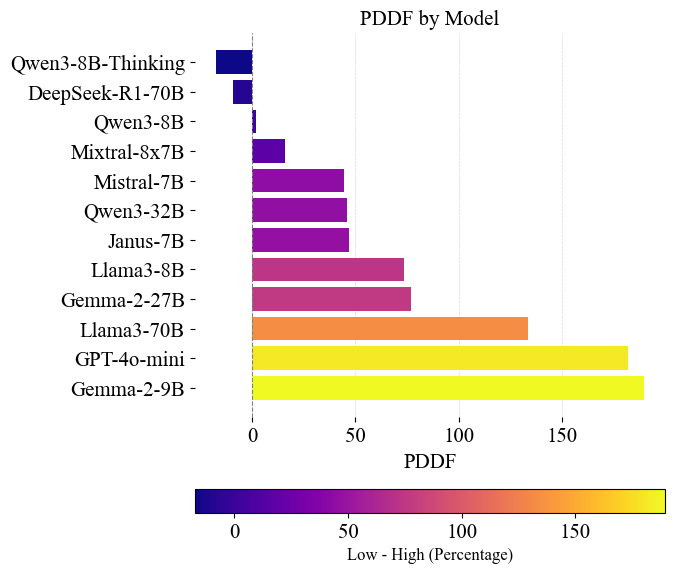

In [53]:
from results_helper import missing_answer_diffplot, filter_axis

data, order = results_dict.get_field_matrix(
    field=["NoPrefInvalid", "PrefInvalid"],
    fixed_keys={
        "dataset": "full",
        "method": "direct",
        "relevance": "relevant",
    },
    axis_keys=["model"]
)
data = np.array(data).squeeze()
print(data.shape)
data = data[:, :-1].astype(np.float32)
models_ref = MODELS[:-1].copy()
print(data)

# Filter by None
data, _, model_names_hb = filter_axis(
    data, 
    axis=0,
    filter_val=None,
    labels_to_filter=MODELS_SHORT,
)
# Filter by 0
data, _, model_names_hb = filter_axis(
    data, 
    axis=0,
    filter_val=0.0,
    labels_to_filter=model_names_hb,
)
print(data.shape)

# missing_answer_hbarplot(
#     data, 
#     keys=models_ref,
#     title="Missing Answer Rate by Model",
#     xlabel="Missing Answer Rate",
#     show=True
# )
low  = data[0, :]
high = data[1, :]
diff = ((high - low) / low * 100)[None]

missing_answer_diffplot(
    diff,
    keys=models_ref,
    title="PDDF by Model",
    xlabel="PDDF",
    show=True
)


## PVR Plot like the one above

(13,)


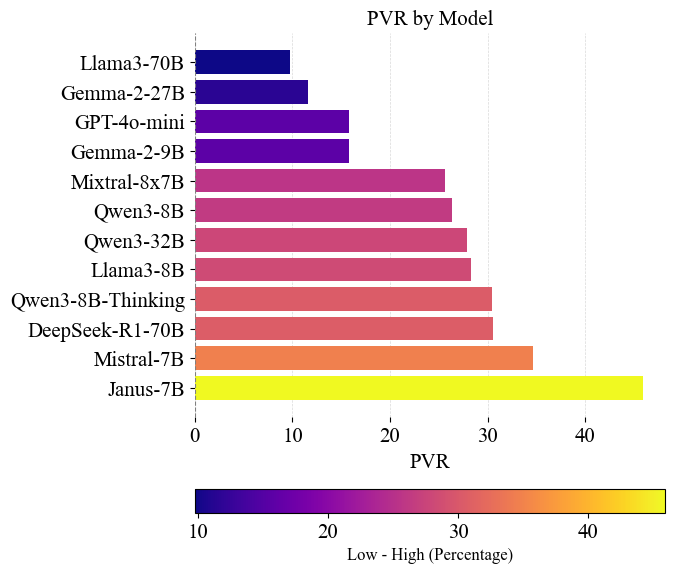

In [55]:
from results_helper import missing_answer_diffplot

data, order = results_dict.get_field_matrix(
    field=["PVR"],
    fixed_keys={
        "dataset": "full",
        "method": "direct",
        "relevance": "relevant",
    },
    axis_keys=["model"]
)
data = np.array(data).squeeze()
print(data.shape)
data = data[:-1].astype(np.float32)
models_ref = MODELS[:-1].copy()
data = data[None]

missing_answer_diffplot(
    data,
    keys=models_ref,
    title="PVR by Model",
    xlabel="PVR",
    show=True
)


## Analyzing accuracy of sampled vs full preferences

1. Llama-3.1-8B
2. Janus-7B

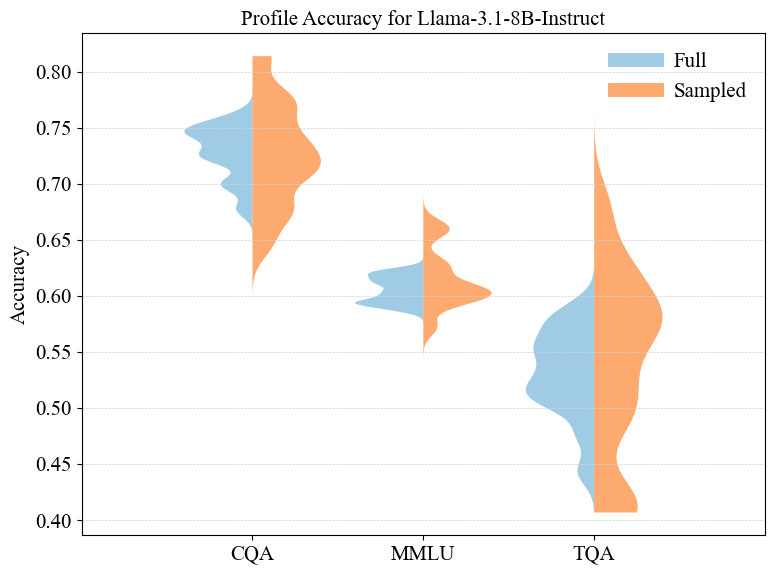

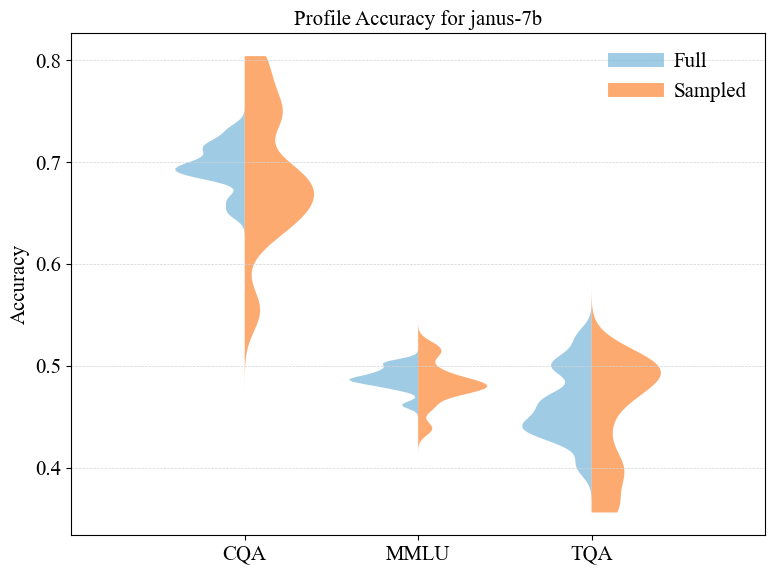

In [ ]:
from results_helper import compare_profile_accuracy
# Llama-8B

llama_indiv_dataset_paths = [
    "Llama-3.1-8B-Instruct_final.csv",
    "Llama-3.1-8B-Instruct_0.8158839580640529_final.csv",
    "Llama-3.1-8B-Instruct_final.csv",
]

compare_profile_accuracy(
    "Llama-3.1-8B-Instruct",
    llama_indiv_dataset_paths,
    results_dict,
    show=True,
)

janus_indiv_dataset_paths = [
    "janus-7b_final.csv",
    "janus-7b_final.csv",
    "janus-7b_final.csv",
]

compare_profile_accuracy(
    "janus-7b",
    janus_indiv_dataset_paths,
    results_dict,
    show=True,
)

## Plot Aligner Improvements

(4, 5, 4)
[[  4.2998896    4.523481    -4.591564    16.754791  ]
 [  2.8445425    2.5207183    0.34703684 -54.230007  ]
 [ -1.4184374   -1.8580259    6.471731   -71.99634   ]
 [ 12.844296     8.121191    -3.2206423   37.99047   ]]
(4, 4)


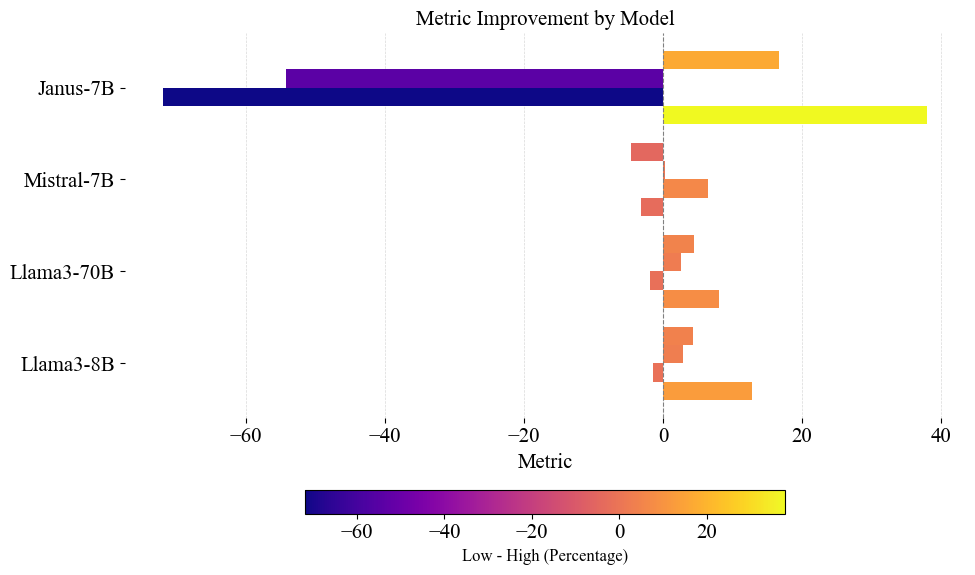

In [79]:
from results_helper import missing_answer_diffplot

data, order = results_dict.get_field_matrix(
    field=["BR", "RER", "AFR", "PVR"],
    fixed_keys={
        "dataset": "full",
        "relevance": "relevant",
    },
    axis_keys=["method", "model"]
)
data = np.array(data).squeeze()
# Take the first 5
data = data[...,:4]
models_ref = MODELS[:4].copy()
print(data.shape)

improvement = (data[:,0] - data[:,-1]).astype(np.float32)
print(improvement)
print(improvement.shape)

missing_answer_diffplot(
    improvement,
    keys=models_ref,
    title="Metric Improvement by Model",
    xlabel="Metric",
    series_labels=["BR", "RER", "AFR", "PVR"],
    show=True
)

(4, 5, 1)
[[ 16.754791]
 [-54.230007]
 [-71.99634 ]
 [ 37.99047 ]]
(4, 1)


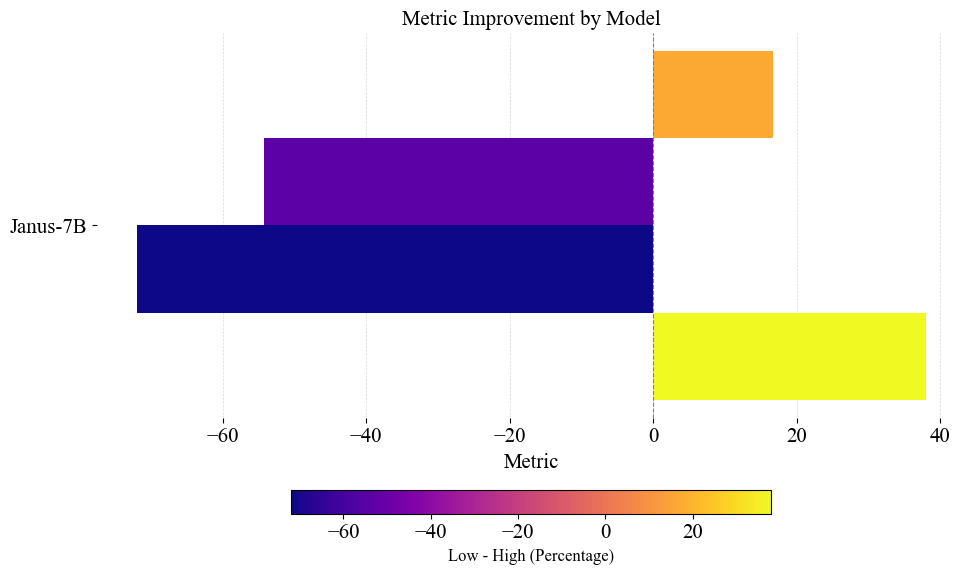

In [78]:
from results_helper import missing_answer_diffplot

data, order = results_dict.get_field_matrix(
    field=["BR", "RER", "AFR", "PVR"],
    fixed_keys={
        "dataset": "full",
        "relevance": "relevant",
    },
    axis_keys=["method", "model"]
)
data = np.array(data).squeeze()
# Take the first 5
data = data[...,3:4]
models_ref = MODELS[3:4].copy()
print(data.shape)

improvement = (data[:,0] - data[:,-1]).astype(np.float32)
print(improvement)
print(improvement.shape)

missing_answer_diffplot(
    improvement,
    keys=models_ref,
    title="Metric Improvement by Model",
    xlabel="Metric",
    series_labels=["BR", "RER", "AFR", "PVR"],
    show=True
)